In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
from tabulate import tabulate
from scipy.stats import laplace, uniform
import math

## Постановка задачи:
Провести дисперсионный анализ с применением крритерия Фишера по данным регистраторов для одного сигнала. Определить области однородности сигнала, переходные области, шум/ фон. Длину сигнала взять равной 1024.

	


In [163]:
signal_size = 1024
file_name = "wave_ampl.txt"
my_types = {"b":"Фон", "t":"Переход", "s":"Сигнал"}
signal_num = 18

In [164]:
def get_data(filename, signal_size):
    data = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            remove_dirst_str = line.replace("[", "")
            remove_next_str = remove_dirst_str.replace("]", "")
            data.append(remove_next_str.split(", "))

    data_float_format = []
    for item in data:
        data_float_format.append([float(x) for x in item])

    new_data = np.asarray(data_float_format)
    data = np.reshape(new_data, (new_data.shape[1] // signal_size, signal_size))
    return data

In [165]:
def draw_signal_data(signal):
    plt.title("Signal")    
    plt.grid()
    plt.plot(signal, 'magenta')
    plt.savefig('signal.png')
    plt.show()

In [166]:
def draw_hist(signal):
    plt.title("Signal histogram")
    plt.grid() 
    bin = int(math.log2(len(signal) + 1))
    hist = plt.hist(signal, bins=bin)  
    plt.savefig('hist.png')
    plt.show()
    return bin, hist

In [167]:
def get_areas(signal):
    bin, hist = draw_hist(signal)
    
    count = []
    start = []
    end = []
    types = [0] * bin

    for i in range(bin):
        count.append(hist[0][i])
        start.append(hist[1][i])
        end.append(hist[1][i + 1])

    sortedHist = sorted(count)
    repeat = 0
    for i in range(bin):
        for j in range(bin):
            if sortedHist[len(sortedHist) - 1 - i] == count[j]:
                if repeat == 0: types[j] = "b"
                elif repeat == 1: types[j] = "s"
                else: types[j] = "t"
                repeat += 1

    return start, end, types

In [168]:
def get_converted_data(signal, start, end, types):
    new_types = [0] * len(signal)
    zones = []
    zones_type = []

    for i in range(len(signal)):
        for j in range(len(types)):
            if (signal[i] >= start[j]) and (signal[i] <= end[j]):
                new_types[i] = types[j]

    currType = new_types[0]
    start = 0
    for i in range(len(new_types)):
        if currType != new_types[i]:
            end = i
            zones_type.append(currType)
            zones.append([start, end])
            start = end
            currType = new_types[i]

    if currType != zones_type[len(zones_type) - 1]:
        zones_type.append(currType)
        zones.append([end, len(signal) - 1])
        
    signal_data = list()
    for limits in zones:
        data_part = list()
        for j in range(limits[0], limits[1]):
            data_part.append(signal[j])
        signal_data.append(data_part)

    return zones, zones_type, signal_data

In [169]:
def draw_areas(signal, area_data, types):
    plt.title("Divided areas for a signal without outliers")
    print(types)
    for i in range(len(area_data)):
        if types[i] == "b":
            color_ = 'r'
        if types[i] == "s":
            color_ = 'g'
        if types[i] == "t":
            color_ = 'b'
        plt.plot([num for num in range(area_data[i][0], area_data[i][1], 1)], signal_data[i], color=color_, label=my_types[types[i]])
   
    plt.grid()
    plt.legend()
    plt.savefig('areas.png')
    plt.show()

In [170]:
def get_inter_group_D(signal):
    summ = 0.0
    mean = np.empty(signal.shape[0])
    for i in range(len(signal)):
        mean[i] = np.mean(signal[i])
    meanMean = np.mean(mean)

    for i in range(len(mean)):
        summ += (mean[i] - meanMean) ** 2
    summ /= (signal.shape[0] - 1)

    return len(signal) * summ


def get_intar_group_D(signal):
    result = 0.0
    for i in range(signal.shape[0]):
        mean = np.mean(signal[i])
        summ = 0.0
        for j in range(signal.shape[1]):
            summ += (signal[i][j] - mean) ** 2
        summ /= (signal.shape[0] - 1)
        result += summ

    return result / signal.shape[0]


def get_F(signal, k):
    newSizeY = int(signal.size / k)
    newSizeX = k
    print("k = " + str(k))
    splitData = np.reshape(signal, (newSizeX, newSizeY))
    interGroup = get_inter_group_D(splitData)
    print("Inter = " + str(interGroup))
    intraGroup = get_intar_group_D(splitData)
    print("Intar = " + str(intraGroup))
    print("F = " + str(interGroup / intraGroup))
    return interGroup / intraGroup


def get_K(num):
    i = 4
    while num % i != 0:
        i += 1
    return i


def get_Fisher(signal, area_data):
    fishers = []
    for i in range(len(area_data)):
        start = area_data[i][0]
        finish = area_data[i][1]
        k = get_K(finish - start)
        while k == finish - start:
            finish += 1
            k = get_K(finish - start)
        fishers.append(get_F(signal[start:finish], int(k)))
    return fishers

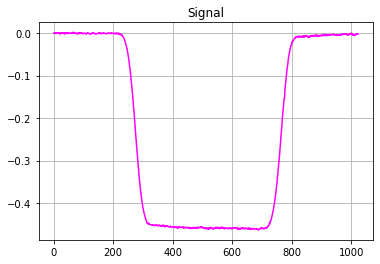

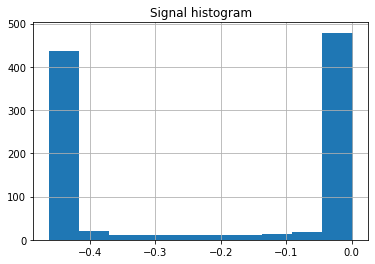

In [171]:
signal = get_data(file_name, signal_size)
signal = signal[signal_num]
draw_signal_data(signal)
start, finish, types = get_areas(signal)

In [172]:
zones, zones_types, signal_data = get_converted_data(signal, start, finish, types)
print(get_Fisher(signal, zones))

k = 4
Inter = 3.802969965507401e-05
Intar = 0.0005496889159818828
F = 0.06918403946192618
k = 6
Inter = 0.10262108570572664
Intar = 0.0006147307623573052
F = 166.93663631246636
k = 4
Inter = 5.100911798514388e-05
Intar = 0.0011512230722079248
F = 0.04430863072203179
k = 5
Inter = 0.08551932864081377
Intar = 0.0013646711586216948
F = 62.66661979372928
k = 5
Inter = 0.00010741346878913218
Intar = 0.00020892286220927143
F = 0.5141297972528229
[0.06918403946192618, 166.93663631246636, 0.04430863072203179, 62.66661979372928, 0.5141297972528229]


['b', 't', 's', 't', 'b']


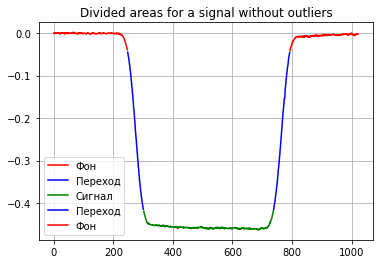

In [173]:
types = ['b', 't', 's', 't', 'b']
draw_areas(signal_data, zones, types)

In [174]:
print(zones)

[[0, 248], [248, 302], [302, 738], [738, 793], [793, 1023]]
